In [1]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install annoy mtcnn opencv-python keras_applications



  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-yk8s6l3b
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-yk8s6l3b
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8298 sha256=cd0959ee70cc32ae34a6eec3aeda627b5a95d4dd5501339c366e292f0caa28e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-mc9wr9z9/wheels/62/cd/e0/3a2d2fe84d014324aed54d420cab52df65a774d9b296c63996
Successfully built keras-vggface
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.2 MB/s eta 0:00:00
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=550809 sha256=6ba66e62d5a77e24237f

In [26]:
#@title Dataset of 18 celebrities.

import cv2
import imutils

import os

# Upload the celebrity-18 dataset from here:
# https://drive.google.com/file/d/15SK4cTePa20TYOZmx8qNqXI-v4GIozIq/view?usp=drive_link
# on the left pane of colab.
!unzip celebrity-18.zip


def read_image_array(filepath):
  img = cv2.imread(filepath)
  img = imutils.resize(img, width=400)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

names = list([])
id_to_images = dict()
image_to_id = dict()
root_dir = "Celebrity Faces Dataset"
for celebrity in os.listdir(root_dir):
  id = len(names)
  names.append(celebrity)
  img_files = os.listdir(f"{root_dir}/{celebrity}")
  id_to_images[id] = [f"{root_dir}/{celebrity}/{f}" for f in img_files]
  for file in img_files:
    image_to_id[file] = id

names

['Nicole Kidman',
 'Kate Winslet',
 'Denzel Washington',
 'Hugh Jackman',
 'Scarlett Johansson',
 'Brad Pitt',
 'Natalie Portman',
 'Johnny Depp',
 'Tom Cruise',
 'Angelina Jolie',
 'Robert Downey Jr',
 'Sandra Bullock',
 'Leonardo DiCaprio',
 'Jennifer Lawrence',
 'Tom Hanks',
 'Will Smith',
 'Megan Fox']

In [64]:
#@title 0-shot: Find the nearest celebrity in pre-trained model from new dataset.
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
model = VGGFace(model='resnet50')

img = tf.keras.utils.load_img(id_to_images[0][0], target_size=(224, 224))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2)
preds = model.predict(x)
print('Predicted:', utils.decode_predictions(preds))


1346516/1346516 [==============================] - 0s 0us/step
Predicted: [[["b' Daniel_Mullback'", 0.0036607669], ["b' Marta_S\\xc3\\xa1nchez'", 0.0033633956], ["b' Angelique_Morgan'", 0.0031592539], ["b' Shauna_Sand'", 0.0023918424], ["b' Donatella_Versace'", 0.0023599572]]]


1/1 [==============================] - 1s 1s/step


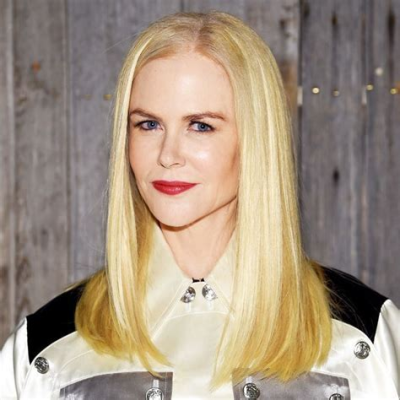

In [53]:
#@title Face detection and encoding.
from mtcnn.mtcnn import MTCNN
from PIL import Image
import numpy as np

from annoy import AnnoyIndex
from typing import Tuple, Dict, List
from keras_vggface import utils
from keras_vggface.utils import preprocess_input

face_detector = MTCNN() # Could use OpenCV or Viola Jones or something else.
encoder_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')


def get_face_descriptors(img):
  """
  Returns tuple of (encoding, bounding_box) for each face in image.
  """
  results = face_detector.detect_faces(img)
  if not results:
    print("No detected faces")
    return None, None

  face_descriptors = []
  for result in results:
    x1, y1, width, height = result['box']
    x1 = max(x1, 0.0)
    y1 = max(y1, 0.0)
    x2, y2 = x1 + width, y1 + height
    image = Image.fromarray(
        img[y1:y2, x1:x2]).resize((224,224))
    face_array = np.asarray(image)
    samples = preprocess_input(np.asarray(face_array, 'float32'), version=2)
    samples = np.expand_dims(samples, axis=0)
    encoding = encoder_model.predict(samples)
    face_descriptors.append((encoding[0], (x1, y1, width, height)))
  return face_descriptors

img_array = read_image_array(id_to_images[0][0])
descriptor = get_face_descriptors(img_array)[0]
Image.fromarray(img_array)


In [54]:
print(f"Bounding box: {descriptor[1]}")
print(f"Face embedding: {descriptor[0].tolist()}")

Bounding box: (126, 55, 120, 170)
Face embedding: [0.2769727408885956, 0.06567426025867462, 1.0067615509033203, 0.0, 3.6021218299865723, 0.5026994943618774, 0.0, 0.0, 2.652670383453369, 0.0, 1.5789021253585815, 0.27281761169433594, 4.527498245239258, 0.0, 0.0019799519795924425, 0.5500742793083191, 0.023517988622188568, 0.0, 3.0026934146881104, 0.0019434860441833735, 0.09682364016771317, 4.5683441162109375, 0.03773252293467522, 0.9026370048522949, 0.30480948090553284, 7.252415657043457, 0.9869399070739746, 0.0, 0.8797395825386047, 0.06632144749164581, 0.06964783370494843, 0.0, 2.4907400608062744, 0.32192686200141907, 0.0, 4.438454627990723, 0.0, 0.020495422184467316, 0.058986250311136246, 0.0, 0.0, 0.0, 0.0, 0.6177238821983337, 0.0, 0.4734870493412018, 0.18276169896125793, 2.8806607723236084, 0.0, 4.591066837310791, 0.0, 4.891364097595215, 1.422932505607605, 0.0, 0.0, 0.0, 3.113920211791992, 0.0, 0.0, 2.2175209522247314, 0.0, 0.030474787577986717, 4.4322829246521, 3.462860107421875, 6.3

In [56]:
#@title Building the ANN index.

ann_index = AnnoyIndex(2048, 'angular')
for id, images in id_to_images.items():
  for image in images[0:5]:
    face_descriptors = get_face_descriptors(read_image_array(image))
    if not face_descriptors:
      print(f"Warning: no descriptor for {image}")
      continue
    if len(face_descriptors) > 1:
      print(f"Warning: more than two faces found in {image}")
    ann_index.add_item(id, face_descriptors[0][0])
ann_index.build(10)


1/1 [==============================] - 0s 182ms/step


True

In [66]:
#@title Face recognition.


def recognize(img, ann_index):
  face_descriptors = get_face_descriptors(img)
  data = []
  for index, face_descriptor in enumerate(face_descriptors):
    enc, bbox = face_descriptor
    cv2.rectangle(img, bbox, (255,0,0), 2)
    temp_data = {}
    temp_data["bbox"] = bbox
    results = ann_index.get_nns_by_vector(enc, 10, search_k=-1, include_distances=True)
    return {
        f"{names[id]} ({id})": distance
        for id, distance in zip(results[0], results[1])
    }

recognize(read_image_array(id_to_images[0][-1]), ann_index)

1/1 [==============================] - 0s 175ms/step


{'Nicole Kidman (0)': 0.5493634939193726,
 'Kate Winslet (1)': 1.0861486196517944,
 'Natalie Portman (6)': 1.128688097000122,
 'Angelina Jolie (9)': 1.1424298286437988,
 'Tom Cruise (8)': 1.1462359428405762,
 'Brad Pitt (5)': 1.169741153717041,
 'Leonardo DiCaprio (12)': 1.1744896173477173,
 'Megan Fox (16)': 1.1821599006652832,
 'Sandra Bullock (11)': 1.1857844591140747,
 'Hugh Jackman (3)': 1.1860864162445068}

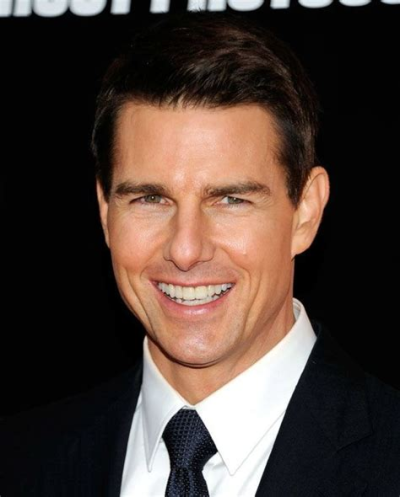

In [67]:
Image.fromarray(read_image_array(id_to_images[8][-1]))

In [68]:
recognize(read_image_array(id_to_images[8][-1]), ann_index)

1/1 [==============================] - 0s 188ms/step


{'Tom Cruise (8)': 0.7879090309143066,
 'Brad Pitt (5)': 1.0635229349136353,
 'Sandra Bullock (11)': 1.072849988937378,
 'Leonardo DiCaprio (12)': 1.094602108001709,
 'Natalie Portman (6)': 1.0985807180404663,
 'Hugh Jackman (3)': 1.1270081996917725,
 'Denzel Washington (2)': 1.1385934352874756,
 'Kate Winslet (1)': 1.1408392190933228,
 'Nicole Kidman (0)': 1.1484901905059814,
 'Robert Downey Jr (10)': 1.1793146133422852}